In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
data = pd.read_csv('salary_data.csv')

#### Preprocessing
- Drop na
- Standardize education, gender cols
- Rename cols for easier work

In [4]:
data.rename(columns={
    'Age': 'age',
    'Gender': 'gender',
    'Education Level': 'edu', 
    'Job Title': 'job',
    'Years of Experience':'exp', 
    'Salary': 'salary'}, inplace=True)
data.dropna(inplace=True)
#normalize job titles and education levels
data['gender'] = data['gender'].str.lower().str.strip()
data['job'] = data['job'].str.lower().str.strip()
data['edu'] = data['edu'].str.lower().str.strip()
data['edu'].replace(
    {"bachelor's": "bachelor", 
     "master's": "master", 
     "bachelor's degree": "bachelor",
     "master's degree": "master"}, 
inplace=True)

#### Define Functions

In [5]:
import statsmodels.api as sm 
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
def anova_pairwise_tukeyhsd(df, col1, col2):
    fig = plt.figure(figsize=(4, 2))
    ax1 = fig.add_subplot(1, 1, 1)
    sns.boxplot(x=col1, y=col2, data=df, palette="Set3", ax=ax1)
    plt.show()

    model = ols(f'{col2} ~ C({col1})', data=df).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    print(anova_table)
    print('\n')
    m_comp = pairwise_tukeyhsd(endog=df[col2], groups=df[col1], alpha=0.05)
    print(m_comp)

In [6]:
from scipy.stats import chi2_contingency, chi2
def plot_crosstab_and_show_dependency(df, col1, col2):
    crosstab = pd.crosstab(df[col1], df[col2])
    crosstab.plot(kind='bar', stacked=True, figsize=(5, 3))
    plt.title(f'{col1} vs {col2}')
    plt.show()

    stat, p, dof, expected =chi2_contingency(crosstab)
    print(f'p-value: {p}')
    print(f'dof: {dof}')

    prob = 0.975
    critical = chi2.ppf(prob, dof)
    print(f'probability: {prob}, critical: {critical}, stat: {stat}')

    alpha = 1 - prob
    print(f'alpha (significant): {alpha}, p-value: {p}')
    if p <= alpha:
        print(f'{col1} dependent {col2} (reject H0)')
    else:
        print(f'{col1} independent {col2}(fail to reject H0)')

In [7]:
def num_univariate_analysis(data, col: str):
    #Descriptive statistics
    print(data[col].describe(include='all'))
    col_median = data[col].median()
    col_mode = data[col].mode().iloc[0]
    col_range = data[col].max() - data[col].min()
    col_variance = data[col].var()
    col_skew = data[col].skew()
    col_kurt = data[col].kurt()

    print(f"Median {col_median}")
    print(f"Mode {col_mode}")
    print(f"Range {col_range}")
    print(f"Var {col_variance}")
    print("****************************************************")

    # Histogram
    plt.figure(figsize=(8, 5))
    plt.subplot(1, 3, 1)
    sns.histplot(data[col], kde=True)
    plt.subplot(1, 3, 2)
    plt.hist(data[col])
    plt.subplot(1, 3, 3)
    plt.pie(data[col].value_counts(), labels=data[col].value_counts().index, autopct='%1.1f%%')
    plt.show()
    print(f"Skew {col_skew}")
    print(f"Kurt {col_kurt}")
    if col_skew > 0:
        print("Phân phối lệch phải")
    else:
        print("Phân phối lệch trái")
    
    if col_kurt > 0:
        print("Phân phối nhọn hơn phân phối chuẩn")
    else:
        print("Phân phối có độ nhọn thấp hơn phân phối chuẩn")
    print("****************************************************")

    col_Q1 = data[col].quantile(0.25)
    col_Q3 = data[col].quantile(0.75)
    col_IQR = col_Q3 - col_Q1
    print(f"Q1 - Q3: {col_Q1} - {col_Q3}")
    print(f"IQR {col_IQR}")

    # Boxplot, Outliers
    plt.figure(figsize=(2,2))
    plt.boxplot(data[col])
    plt.show()
    col_outliers_upper_num = data[data[col] > (col_Q3 + 1.5*col_IQR)].shape[0]
    col_outliers_lower_num = data[data[col] < (col_Q1 - 1.5*col_IQR)].shape[0]
    col_outliers_per = (col_outliers_upper_num + col_outliers_lower_num)/data.shape[0] * 100
    print(f"Number of outliers: {col_outliers_upper_num + col_outliers_lower_num}")
    print(f"Number of upper outliers: {col_outliers_upper_num}")
    print(f"Number of lower outliers: {col_outliers_lower_num}")
    print(f"Percentage of outliers: {col_outliers_per}%")
    # vì outlier có tỉ lệ nhỏ (<1%) nên có thể không cần loại bỏ outlier

In [8]:
class PlotType(enumerate):
    HIST = 'hist'
    PIE = 'pie'
    BAR = 'bar'

def cat_univariate_analysis(data:pd.DataFrame, fig_size=(10, 5), exclude_cols=[], num_cols=3, plot_type=PlotType.HIST):
    i = 0
    category_cols = [col for col in data.columns if data[col].dtype == 'object']
    num_rows = len(category_cols) // num_cols + 1
    fig = plt.figure(figsize=fig_size)
    for col in category_cols:
        if col in exclude_cols:
            continue
        i += 1
        fig.add_subplot(num_rows, num_cols, i)
        if plot_type == PlotType.HIST:
            sns.histplot(data[col])
        elif plot_type == PlotType.PIE:
            plt.pie(data[col].value_counts(), labels=data[col].value_counts().index, autopct='%1.1f%%')
        elif plot_type == PlotType.BAR:
            sns.barplot(x=data[col].value_counts().index, y=data[col].value_counts())
        plt.xticks(rotation=90)
        plt.title(col)
    plt.tight_layout()
    plt.show()

In [9]:
numbers_cols = [col for col in data.columns if data[col].dtype != 'object']
description = data.describe()
modes = data.mode().iloc[0] # (1,33)
description.loc['mode'] = modes
description.loc['var'] = data[numbers_cols].var()
standard_error = data[numbers_cols].sem()
description.loc['std'] = standard_error
kurtosis = data[numbers_cols].kurtosis()
description.loc['kur'] = kurtosis
skewness = data[numbers_cols].skew()
description.loc['skew'] = skewness
range = data[numbers_cols].max() - data[numbers_cols].min()
description.loc['range'] = range
description

,age,exp,salary
count,6698.000000,6698.000000,6.698000e+03
mean,33.623022,8.095178,1.153293e+05
std,0.093056,0.074049,6.450262e+02
min,21.000000,0.000000,3.500000e+02
25%,28.000000,3.000000,7.000000e+04
50%,32.000000,7.000000,1.150000e+05
75%,38.000000,12.000000,1.600000e+05
max,62.000000,34.000000,2.500000e+05
mode,27.000000,2.000000,1.400000e+05
var,58.000169,36.727128,2.786762e+09


#### Drill to data jobs only

In [10]:
# get values contain Data
data_jobs = data['job'].value_counts().index
data_keywords = ['data', 'analyst']
data_jobs = [job for job in data_jobs if any(keyword in job for keyword in data_keywords)]

remove_jobs = ['data entry clerk', 'help desk analyst']
data_jobs = [job for job in data_jobs if job not in remove_jobs]

software_jobs = data['job'].value_counts().index
software_keywords = [
    'software', 'engineer', 
    'developer', 'programmer', 
    'mobile', 'full stack', 
    'front end', 'back end', 'web']
remove_jobs = ['software project manager', 'network engineer', 'project engineer', 'junior web designer', 'senior data engineer']
software_jobs = [job for job in software_jobs if any(keyword in job for keyword in software_keywords)]
software_jobs = [job for job in software_jobs if job not in remove_jobs]

data['job_type'] = data['job'].apply(lambda x: 'data' if x in data_jobs else ('software' if x in software_jobs else 'other'))

In [11]:
df_other = data[data['job_type'] == 'other']

#### Number Univariate analysis
- Về exp, mức phổ biến là từ 1 - 9 năm, từ 3 - 11 exp tỉ lệ giảm, và trên 20 - 30 năm tỉ lệ này còn thấp hơn => phân phối lệch phải mạnh, ngoại lai là > 25.5 và có 75 ngoại lai (làm việc nhiều hơn 25.5 năm). Median là 7, mean là 8
- Về age, phổ biến là khoảng 27 - 38 tuổi, ngoài khoảng này ra thì tỉ lệ các nhóm tuổi còn lại khá thấp, đa phần đều là những người nằm trong độ tuổi vàng lao động (22 - 40), mode(xuất hiện nhiều nhất) là 33, mean là 33, Median là 32
- Range salary phổ biến từ 55000$ - 140000$, mode là 120000$, median và mean là 95000$, 101867$. Phân phối lệch phải và không có ngoại lai

count      2846.000000
mean     101867.357695
std       53239.539522
min         500.000000
25%       55000.000000
50%       95000.000000
75%      140000.000000
max      250000.000000
Name: salary, dtype: float64
Median 95000.0
Mode 120000.0
Range 249500.0
Var 2834448568.5517983
****************************************************


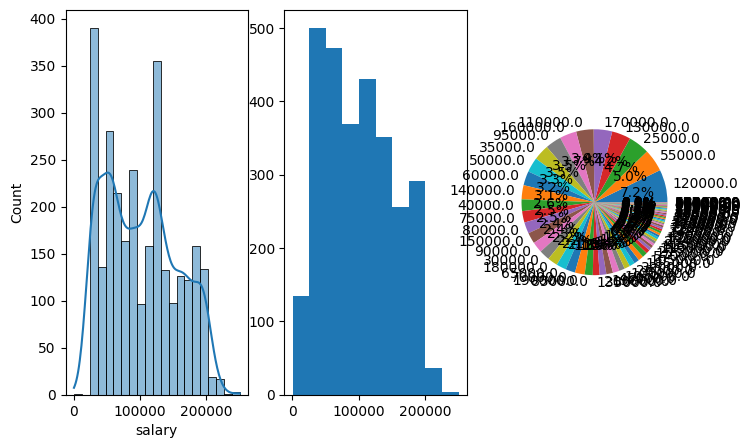

Skew 0.28723088604169755
Kurt -1.0111133544750115
Phân phối lệch phải
Phân phối có độ nhọn thấp hơn phân phối chuẩn
****************************************************
Q1 - Q3: 55000.0 - 140000.0
IQR 85000.0


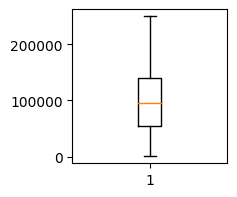

Number of outliers: 0
Number of upper outliers: 0
Number of lower outliers: 0
Percentage of outliers: 0.0%


In [24]:
# num_univariate_analysis(df_other, 'exp')
# num_univariate_analysis(df_other, 'age')
num_univariate_analysis(df_other, 'salary')

#### Category Univariate Analysis
Trong tập dữ liệu:
- Nữ chiếm 55%, nam chiếm 45%
- Bằng cấp 3 chiếm 14.3%. Bằng Cứ nhân chiếm 45%, bằng thạc sĩ chiếm 28%, bằng tiến sĩ chiếm 15.5%
- Xét 100% nhóm các ngành thuộc ngách other

In [16]:
category_cols = [col for col in df_other.columns if df_other[col].dtype == 'object']
for col in category_cols:
    print(f"{col} have {df_other[col].nunique()} unique values: {df_other[col].unique()}")

gender have 2 unique values: ['male' 'female']
edu have 4 unique values: ['phd' 'bachelor' 'master' 'high school']
job have 146 unique values: ['senior manager' 'sales associate' 'director' 'product manager'
 'sales manager' 'marketing coordinator' 'senior scientist' 'hr manager'
 'project manager' 'customer service rep' 'operations manager'
 'marketing manager' 'data entry clerk' 'sales director'
 'vp of operations' 'it support' 'recruiter' 'financial manager'
 'social media specialist' 'senior consultant' 'product designer' 'ceo'
 'accountant' 'marketing specialist' 'technical writer' 'hr generalist'
 'project engineer' 'customer success rep' 'sales executive' 'ux designer'
 'operations director' 'network engineer' 'administrative assistant'
 'strategy consultant' 'copywriter' 'account manager'
 'director of marketing' 'help desk analyst' 'customer service manager'
 'event coordinator' 'vp of finance' 'graphic designer' 'ux researcher'
 'social media manager' 'director of operations'

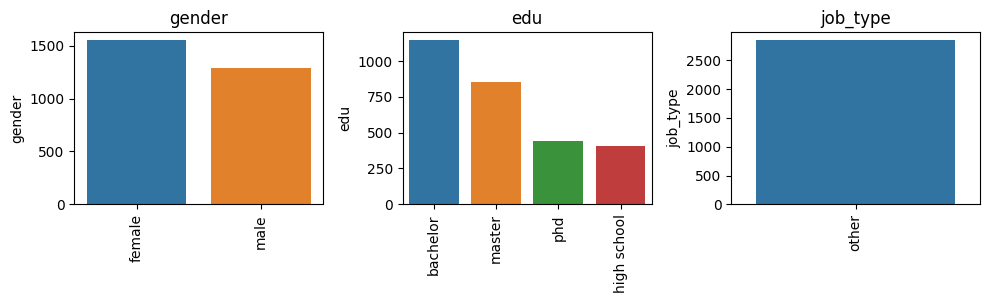

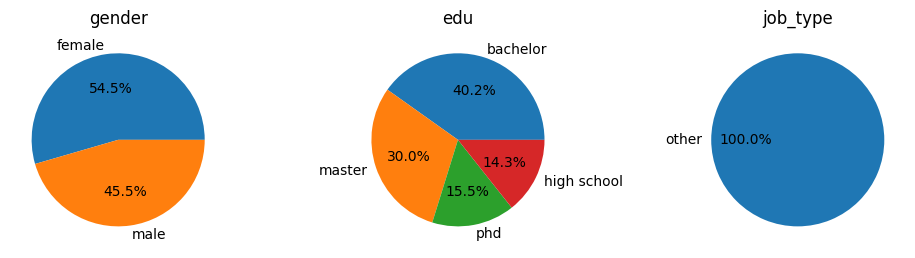

In [14]:
cat_univariate_analysis(df_other, fig_size=(10, 5), exclude_cols=['job'], num_cols=3, plot_type=PlotType.BAR)
cat_univariate_analysis(df_other, fig_size=(10, 5), exclude_cols=['job'], num_cols=3, plot_type=PlotType.PIE)

#### Number vs Number Multivariate Analysis
Dựa vào correlation matrix, Ta thấy exp và age tương quan mạnh, điều này là dễ hiểu, vì càng làm lâu thì tuổi càng lớn, có một số người thì bắt đầu sự nghiệp muộn. Salary tương quan mạnh với exp hơn là với age (Và ở trong nhóm ngành về khác phần mềm thì còn mạnh hơn khoảng 0.1 điểm). 

Theo T-test hypothesis test

In [15]:
df_other.corr()

C:\Users\PC\AppData\Local\Temp\ipykernel_4180\1231328646.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_other.corr()


,age,exp,salary
age,1.000000,0.926620,0.732475
exp,0.926620,1.000000,0.893239
salary,0.732475,0.893239,1.000000


#### Category vs Category Multivariate Analysis
Dựa vào chi2 dependency hypothesis testing, ta kết luận
- Trình độ học vấn có phụ thuộc vào gender, hãy xem xét kĩ hơn với phân tích anova

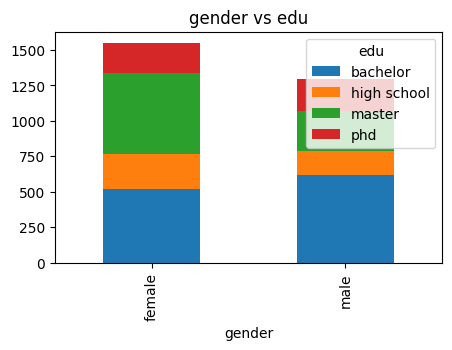

p-value: 8.693018106518974e-21
dof: 3
probability: 0.975, critical: 9.348403604496148, stat: 96.52213098391833
alpha (significant): 0.025000000000000022, p-value: 8.693018106518974e-21
gender dependent edu (reject H0)


In [18]:
plot_crosstab_and_show_dependency(df_other, 'gender', 'edu')

#### Category vs Number Multivariate Analysis
- Trình độ giáo dục càng cao thì mức lương, tuổi cũng càng lớn (xem cụ thể trong anova table), mỗi cấp giáo dục mức lương chênh từ 40000$ - 60000$, mỗi cấp tuổi tăng 5y (trừ nhóm phd và master), mỗi cấp exp tăng 3.5 - 4y, trừ phd và master (tăng 1.2 năm kinh nghiệm)
- Lương của nam giới hơn lương của nữ khoảng 5200$ ở các nhóm ngành khác ngoài phần mềm, data. Nhưng tuổi của nam cũng cao hơn khoảng 1.8, người thuộc giới tính khác có tuổi cao hơn nam khoảng 5 năm => khá tương đồng với nhóm ngành phần mềm nhưng chênh lệch không lớn bằng
- Kinh nghiệm của **nam giới cao hơn nữ 1.2y**, kinh nghiêm của người thuộc giới tính thứ 3 cao hơn nam khoảng 8 năm....
- Trình độ học vấn của nam và nữ không chênh lệch nhiều trong nhóm ngành khác, không có thông tin liên quan giới tính khác

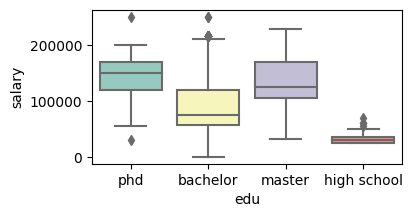

                sum_sq      df           F  PR(>F)
C(edu)    3.589400e+12     3.0  759.923501     0.0
Residual  4.474606e+12  2842.0         NaN     NaN


          Multiple Comparison of Means - Tukey HSD, FWER=0.05           
   group1      group2     meandiff  p-adj    lower       upper    reject
------------------------------------------------------------------------
   bachelor high school -58737.5585   0.0 -64619.8223 -52855.2948   True
   bachelor      master  40030.1745   0.0  35418.2376  44642.1115   True
   bachelor         phd   52220.552   0.0  46498.0916  57943.0124   True
high school      master  98767.7331   0.0   92630.391 104905.0751   True
high school         phd 110958.1105   0.0 103947.8639 117968.3571   True
     master         phd  12190.3775   0.0   6206.0234  18174.7315   True
------------------------------------------------------------------------


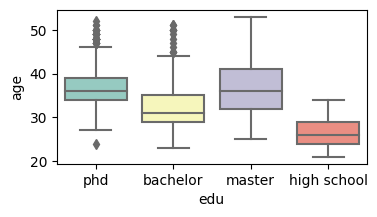

                sum_sq      df          F         PR(>F)
C(edu)    35312.438533     3.0  416.72033  2.436276e-224
Residual  80276.021411  2842.0        NaN            NaN


     Multiple Comparison of Means - Tukey HSD, FWER=0.05      
   group1      group2   meandiff p-adj   lower   upper  reject
--------------------------------------------------------------
   bachelor high school  -5.3932    0.0 -6.1811 -4.6053   True
   bachelor      master   4.5259    0.0  3.9082  5.1436   True
   bachelor         phd   5.0595    0.0   4.293   5.826   True
high school      master   9.9191    0.0   9.097 10.7411   True
high school         phd  10.4527    0.0  9.5137 11.3916   True
     master         phd   0.5336 0.3179  -0.268  1.3352  False
--------------------------------------------------------------


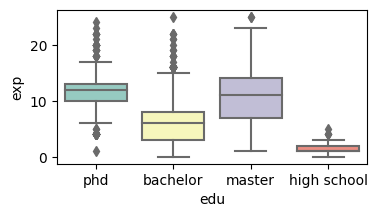

                sum_sq      df           F  PR(>F)
C(edu)    32209.044770     3.0  678.372742     0.0
Residual  44979.256793  2842.0         NaN     NaN


     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
   group1      group2   meandiff p-adj  lower   upper  reject
-------------------------------------------------------------
   bachelor high school  -5.1045   0.0 -5.6943 -4.5148   True
   bachelor      master   4.0511   0.0  3.5887  4.5135   True
   bachelor         phd   5.3088   0.0  4.7351  5.8826   True
high school      master   9.1556   0.0  8.5403  9.7709   True
high school         phd  10.4134   0.0  9.7105 11.1162   True
     master         phd   1.2578   0.0  0.6578  1.8578   True
-------------------------------------------------------------


In [23]:
anova_pairwise_tukeyhsd(df_other, 'edu', 'salary')
anova_pairwise_tukeyhsd(df_other, 'edu', 'age')
anova_pairwise_tukeyhsd(df_other, 'edu', 'exp')

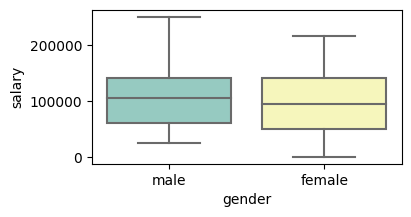

                 sum_sq      df         F    PR(>F)
C(gender)  1.908233e+10     1.0  6.745888  0.009445
Residual   8.044924e+12  2844.0       NaN       NaN


   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1 group2  meandiff p-adj    lower     upper   reject
---------------------------------------------------------
female   male 5199.8688 0.0094 1274.2711 9125.4666   True
---------------------------------------------------------


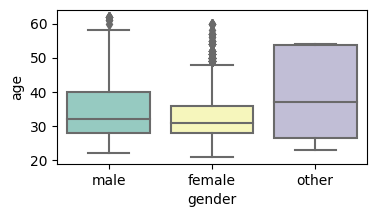

                  sum_sq      df          F        PR(>F)
C(gender)    5811.188153     2.0  50.841981  1.217892e-22
Residual   382615.941886  6695.0        NaN           NaN


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
female   male   1.7921    0.0 1.3565  2.2278   True
female  other   6.9451 0.0018 2.1978 11.6925   True
  male  other    5.153 0.0294 0.4077  9.8984   True
---------------------------------------------------


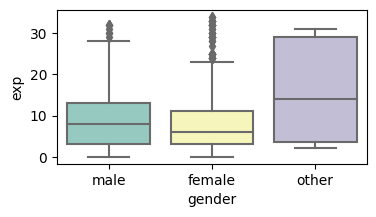

                  sum_sq      df          F        PR(>F)
C(gender)    3346.194852     2.0  46.169321  1.218806e-20
Residual   242615.379386  6695.0        NaN           NaN


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj lower   upper  reject
--------------------------------------------------
female   male   1.1972   0.0 0.8503  1.5441   True
female  other   9.0084   0.0 5.2281 12.7887   True
  male  other   7.8112   0.0 4.0324 11.5899   True
--------------------------------------------------


In [20]:
anova_pairwise_tukeyhsd(df_other, 'gender', 'salary')
anova_pairwise_tukeyhsd(df_other, 'gender', 'age')
anova_pairwise_tukeyhsd(df_other, 'gender', 'exp')

C:\Users\PC\AppData\Local\Temp\ipykernel_4180\321661135.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_other['edu_num'] = df_other['edu'].replace({


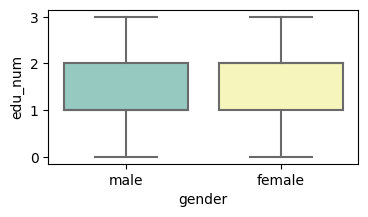

                sum_sq      df         F    PR(>F)
C(gender)     2.360745     1.0  2.795269  0.094653
Residual   2401.901026  2844.0       NaN       NaN


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper reject
--------------------------------------------------
female   male  -0.0578 0.0947 -0.1257  0.01  False
--------------------------------------------------


In [22]:
df_other['edu_num'] = df_other['edu'].replace({
    'high school': 0, 
    'bachelor': 1, 
    'master': 2, 
    'phd': 3})
anova_pairwise_tukeyhsd(df_other, 'gender', 'edu_num')